# Machine Learning Engineer Nanodegree Capstone

## Project: Carvana Image Masking Challenge

---
In this Kaggle competition, we would like to develop an algorithm that automatically removes the photo studio background from the pictures of cars from Carvana's inventory. This will allow Carvana to superimpose cars on a variety of backgrounds. We’ll be analyzing a dataset of photos, covering different vehicles with a wide variety of year, make, and model combinations.

![Sample Car Editing](../images/sample_image.png)

It would be our challenge to make the task of automatic background editing comparable or even better than that of the manual photo editing as seen from the image above!

In computer vision, the process of partitioning a digital image into multiple segments (sets of pixels, also known as super-pixels) is called as image segmentation or semantic segmentation. Image segmentation has been used in various fields such as object detection, face recognition and medical imaging. As this task falls under segmenting the image into car and background,  we will also make use of image segmentation techniques that use deep learning models to attempt to automatically detect the car and remove the background from the image.

We will perform the steps in the below order and try to come up with an algorithm that does a good job of masking the car boundaries

### Steps Performed

Below steps will be used to tackle this challenge..

* [Step 0](#step0): Explore the data. Downloaded dataset from [Kaggle](https://www.kaggle.com/c/carvana-image-masking-challenge/data)
* [Step 1](#step1): Evaluation Metric
* [Step 2](#step2): Create a CNN for Image Segmentation
* [Step 3](#step3): Define the rle function
* [Step 4](#step4): Upload and Submit the submission file
* [Step 5](#step5): Observations

---
<a id='step0'></a>
## Step 0: Explore Dataset

### Import the train dataset

On Kaggle, the dataset has been made availble in zip format. We need to downloaded it and extracted it in our current working directory so that we can import it into our notebook. Below are the main files and folders that we would be using.

- `train/`, `train_masks/`, `train_masks.csv` - The training images folder, ground truth masks folder and training csv file in rle format.
- `test/`, `sample_submission.csv` - Test images folder and rle csv file to be populated in space delimited rle format and submitted.

- Usually we load the data into numpy arrays to proceed. But we will not load the entire data into memory as it would consume a lot of memory.
- Instead, we will just load the image ids for now and then use a lazy method like a generator to load the data into memory batchwise while training.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
data = pd.read_csv('train_masks.csv')
train_ids = data['img'].str[:-4]

print("Data.head()")
display(data.head())

print("\ntrain_ids.head()")
display(train_ids.head())

print ("\nTotal number of images: ", len(data))

Data.head()


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...



train_ids.head()


0    00087a6bd4dc_01
1    00087a6bd4dc_02
2    00087a6bd4dc_03
3    00087a6bd4dc_04
4    00087a6bd4dc_05
Name: img, dtype: object


Total number of images:  5088


**Let us look at the data with some example plots**
- We know that every car image is shot from 16 different angles, lets try to visualize all images of a random car in a 4x4 subplot.

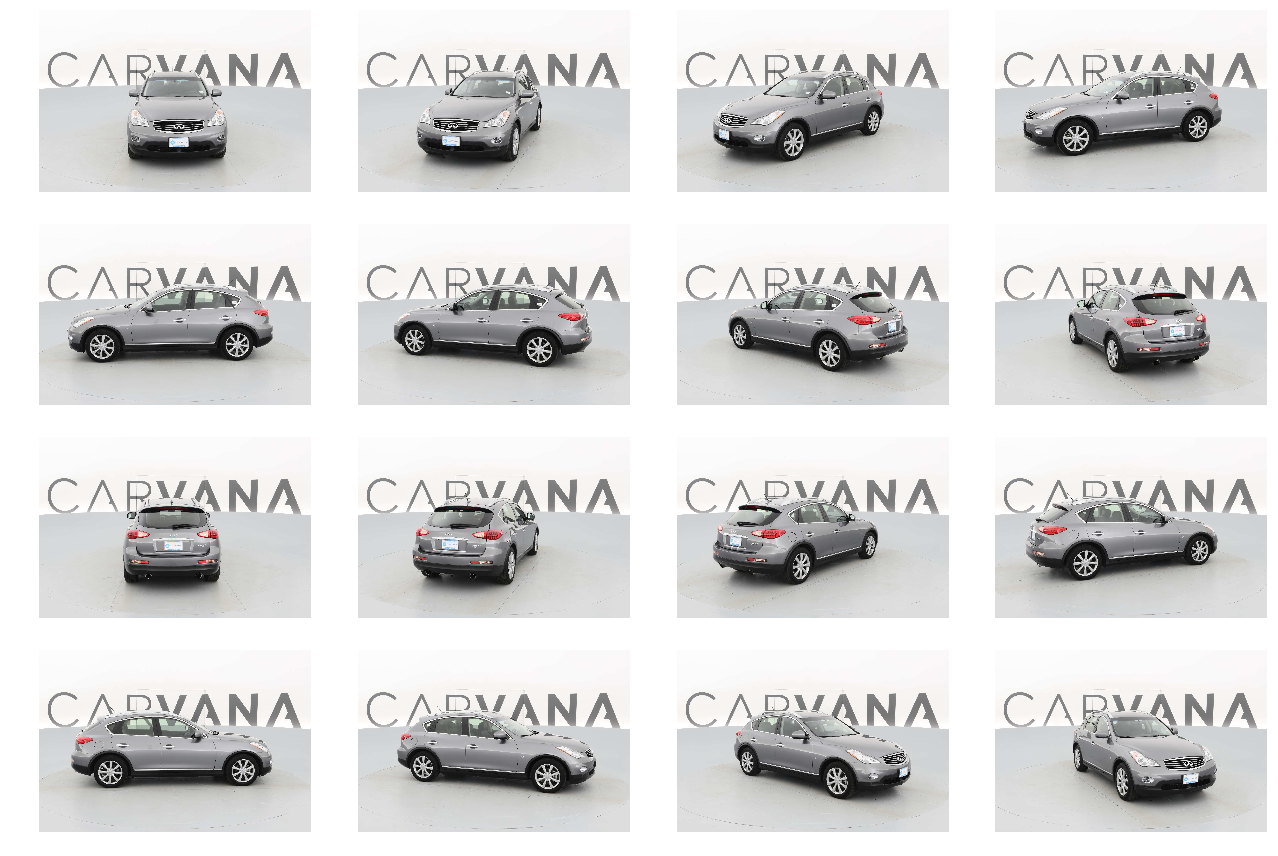

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    img = plt.imread('train/{}.jpg'.format(train_ids[i+1024]))
    plt.imshow(img)

plt.tight_layout(w_pad=0.05)
plt.show()

- We need to predict the car mask ( target variable ) from the car images. Let us view how the data and the target look like for a random car image.

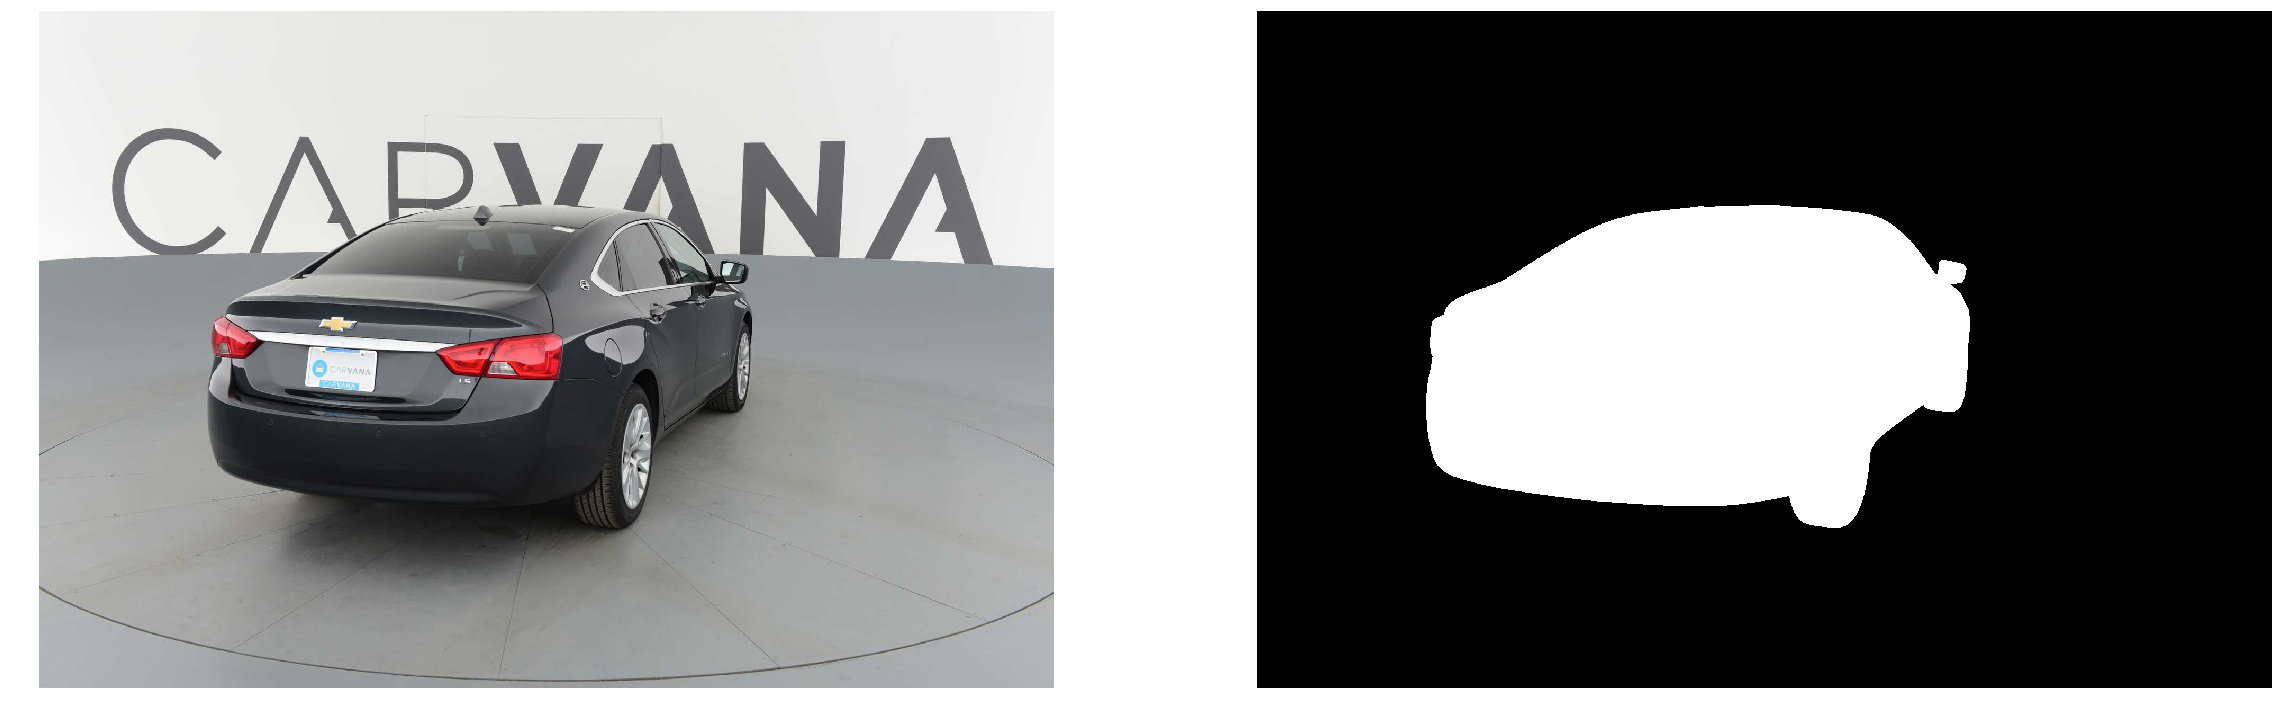

In [3]:
plt.figure(figsize=(40,40))
plt.subplot(1,2,1)
img = plt.imread('train/{}.jpg'.format(train_ids[825]))
plt.axis('off')
plt.imshow(img)
plt.subplot(1,2,2)
img = plt.imread('train_masks/{}_mask.gif'.format(train_ids[825]))
plt.axis('off')
plt.imshow(img)

#plt.tight_layout(w_pad=0.05)
plt.show()

- The training data consists of a total of 318 cars, with 16 images per car shot from different angles.
- The `metadata.csv` file provides us with various additional info such as car brand, model and make. Lets take a look at the cars per brand available to us in the total dataset and compare it with the images available for training.

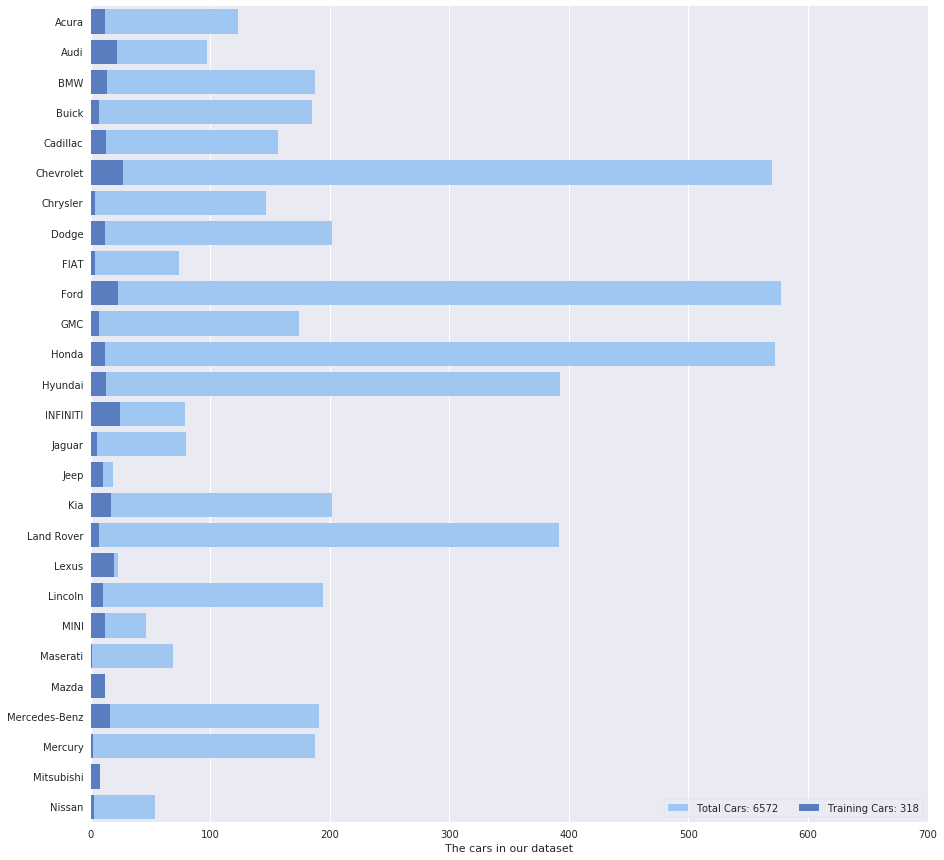

In [4]:
import seaborn as sns

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 15))

metadata = pd.read_csv('metadata.csv')
train_metadata = metadata[metadata['id'].isin(train_ids.str[:-3].drop_duplicates())]
total_cars = metadata.groupby('make').size().reset_index(name = 'counts')
train_cars = train_metadata.groupby('make').size().reset_index(name = 'counts')

sns.set_color_codes("pastel")
sns.barplot(y="make", x="counts", data=total_cars,
            label="Total Cars: 6572", color="b")

sns.set_color_codes("muted")
sns.barplot(y="make", x="counts", data=train_cars,
            label="Training Cars: 318", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 700), ylabel="",
       xlabel="The cars in our dataset")
sns.despine(left=True, bottom=True)

**Some Observations..**
- There are a total of `6572` cars ( `105152` images ) in the dataset of which `318` cars ( `5088` images ) will be used for training and the remaining `6254` cars( `100064` images ) will be used for testing.
- There is a high proportion of Chevrolets, Fords, Hondas and Hyundais in the testing data.
- Lexus, Mazda and Mitsubishi cars have very high representation in the training data.
- However, we may not need to consider this unequal representation while designing our model, as I feel that the CNN will learn the shape of the cars in general, as most of the cars have very similar edges such as sloping windshields, somewhat flat hood and wheels.

Depending on the data available at hand, Data augementation may or may not be necessary. I will go ahead right now without any data augemetation and if results are not satisfactory, I will look at ways to augement the data.

----
<a id='step1'></a>
## Step 1: Evaluation metric

### Dice Coefficient

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: 
![Dice](../images/dice.png) 
- A is the ground truth
- B is the predicted value
- To get a high value of dice coefficient we would need maximum overlap between pixels between the ground truth image and the predicted image.
- Dice Coefficient will be zero for no intersection and 1 for perfect overlap.

Lets build a function `dice_coeff` to calculate the dice score:
It will take in 2 arguments, `y_true` and `y_pred` and return the dice score.

In [5]:
import keras.backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

Using TensorFlow backend.


We have added a smoothening value `smooth = 1` in the above formula as it helps smooth the dice loss ( which is defined below)  and also guards against when the denominator might be zero.

## Dice Loss

Since we want to maximize the Dice coefficient it will be our job to minimize the negative of the Dice Coefficient while training. 
That is, we will minimize the dice loss for updating our weights.
So, our Dice Loss is given by: 

In [6]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

---
<a id='step2'></a>
## Step 2: Create a CNN model


### Pre-process the Data

- As the original images are of a large size (1918 x 1280), we will need to resize the images into a smaller size to reduce the dimensionality of the data and also increase the training time.
- So, we will try with resizing the images to a square of (256 x 256) pixels and check the results and update if required.
- The training masks are in gif format, so we will first convert them to png format as gif is not supported by cv2 and then preprocess them as per the training images.
- As we have the train and test datasets only, we will split the train into training and validation datasets.
-  We will be using Tensorflow and Keras on the top for the model. As Keras requires a 4D tensor (nb_samples, width, height, channel ) we will convert the train images into this format and also normalize the data by dividing by 255.

In [7]:
input_shape = 256
orig_width = 1918
orig_height = 1280
batch_size = 4 # Any higher batch does not fit into my GPU memory.
max_epochs = 100

In [8]:
from sklearn.model_selection import train_test_split

id_train, id_valid = train_test_split(train_ids, test_size=0.2, random_state=42)
print('Total number of images: ', len(train_ids))
print('Number of Training images: ', len(id_train))
print('Number of Validation images: ', len(id_valid))

Total number of images:  5088
Number of Training images:  4070
Number of Validation images:  1018


In [10]:
from PIL import Image
import pandas as pd

for imgs in train_ids:
    img = Image.open('train_masks/{}_mask.gif'.format(imgs))
    img.save('train_masks_gif/{}_mask.png'.format(imgs))

In [9]:
import cv2

def preproc_image(image):
    img = cv2.imread(image)
    img = cv2.resize(img, (input_shape, input_shape))
    return img

def prepoc_image_mask(image):
    mask = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (input_shape, input_shape))
    mask = np.expand_dims(mask, axis=2)
    return mask

Quick Note:

I am using the generator method as seen below which was inspired from a discussion on Kaggle. Initially, I tried to load the data into arrays by using numpy stacks but my CPU could not handle the volume and ran out of memory quite easily. 

The generator, unlike the iterator does not loop over an existing object in memory such as list or dict, but generates or yields the samples with every call as long as the condition is true.

In [10]:
def train_generator():
    while True:
        for start in range(0, len(id_train), batch_size): 
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(id_train)) 
            id_train_batch = id_train[start:end]
            for id in id_train_batch.values:
                img = preproc_image('train/{}.jpg'.format(id))
                mask = prepoc_image_mask('train_masks_gif/{}_mask.png'.format(id))
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch
            
def valid_generator():
    while True:
        for start in range(0, len(id_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(id_valid))
            id_valid_batch = id_valid[start:end]
            for id in id_valid_batch.values:
                img = preproc_image('train/{}.jpg'.format(id))
                mask = prepoc_image_mask('train_masks_gif/{}_mask.png'.format(id))
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

### Develop the model
The architecture for the below model is inspired by 
[The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326)

In [11]:
from keras.models import Model

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Dropout
from keras.layers import Reshape

from keras.optimizers import RMSprop

from keras.regularizers import l2

#Concatenate is used in Sequential Model, concatenate is used in functional API

In [12]:
wd = 1e-4 #Weight decay

** Lets define dense block, transition down and transition up layer. **

In [13]:
def dense_block(x, nlayer, added, wd):
    added = []
    for i in range(nlayer):
        d = BatchNormalization(axis=-1)(x)
        d = Activation('relu')(d)
        d = Conv2D(16, (3,3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=l2(wd))(d)
        d = Dropout(0.2)(d)
        x = concatenate([x,d])
        added.append(d)
    return x, added

def transition_down(x, wd):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(x.get_shape().as_list()[-1], (1,1), strides=(2, 2), kernel_initializer='he_uniform', padding="same", kernel_regularizer=l2(wd))(x)
    x = Dropout(0.2)(x)
    return x

def transition_up(added, wd):
    x = concatenate(added)
    x = Conv2DTranspose(x.get_shape().as_list()[-1], (3,3), strides=(2, 2), kernel_initializer='he_uniform', padding="same", kernel_regularizer=l2(wd))(x)
    return x

### Create the actual Tiramisu model using Keras Functional API.

The below cell contains the downpath of the model. Here the model undergoes convolution gradually.

In [14]:
inputs = Input(shape=(input_shape, input_shape, 3))
c1 = Conv2D(48, (3, 3), kernel_initializer='he_uniform', padding="same", kernel_regularizer=l2(wd))(inputs)
c1 = Dropout(0.2)(c1)
added = []
d1, _  = dense_block(c1, 4, added, wd)
t1 = transition_down(d1, wd)
d2, _ = dense_block(t1, 5, added, wd)
t2 = transition_down(d2, wd)
d3, _ = dense_block(t2, 7, added, wd)
t3 = transition_down(d3, wd)
d4, _ = dense_block(t3, 10, added, wd)
t4 = transition_down(d4, wd)
d5, _ = dense_block(t4, 12, added, wd)
t5 = transition_down(d5, wd)

The below cell contains the bottleneck denseblock. After this dense block, the model will incorporate deconvolutions.

In [15]:
d6, added6 = dense_block(t5, 15, added, wd)

The below cells are the upward path of the model where model begins to regain the original shape.

In [16]:
t5 = transition_up(added6, wd)
s5 = concatenate([t5,d5])
u5, added5 = dense_block(s5, 12, added, wd)
t4 = transition_up(added5, wd)
s4 = concatenate([t4,d4])
u4, added4 = dense_block(s4, 10, added, wd)
t3 = transition_up(added4, wd)
s3 = concatenate([t3,d3])
u3, added3 = dense_block(s3, 7, added, wd)
t2 = transition_up(added3, wd)
s2 = concatenate([t2,d2])
u2, added2 = dense_block(s2, 5, added, wd)
t1 = transition_up(added2, wd)
s1 = concatenate([t1,d1])
u1, added1 = dense_block(s1, 4, added, wd)

In [17]:
classify = Conv2D(1, (1,1),padding="same")(u1)
classify = Activation("sigmoid")(classify)

In [18]:
model = Model(inputs = inputs, outputs= classify)

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 48)  1344        input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 256, 48)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 48)  192         dropout_1[0][0]                  
___________________________________________________________________________________________

### Callbacks for better monitoring:
- Early stopping - Models to stop training if val_loss does not decrease by more than the min_delta value even after the number of epochs = patience.
- ReduceLROnPlateau - Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
- ModelCheckPoint - Callback for Models to save the model weights if the monitor condition is satisfied. Usually a decrease in validation loss value.
- TensorBoard - Will enable TensorBoard visualizations.

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

### Compile the model

In [21]:
model.compile(optimizer=RMSprop(lr=0.0001), loss=dice_loss, metrics=[dice_coeff])

### Train the model

In [22]:
%%time

model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(id_train)) / float(batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(id_valid)) / float(batch_size)))

Note:

I could not capture the training epochs here as an output as i had shutdown my notebook and ssh and let the model train overnight using tmux on google cloud compute. This model takes around 2300s per epoch to train and it ran for 33 epochs.

---- 
<a id='step3'></a>
## Step 3: Define the RLE funtion


Load the test image ids into a list.

In [23]:
test_data = pd.read_csv('sample_submission.csv')
test_ids = test_data['img'].str[:-4]

test_imgs = []
for id in test_ids:
    test_imgs.append('{}.jpg'.format(id))

As Kaggle expects submissions to be sent in rle format, we will need to convert the image masks generated by our model into rle format and then upload them to Kaggle.
Here, I will directly import below, the rle function made available [here](https://www.kaggle.com/stainsby/fast-tested-rle) as it is fast and tested.

In [24]:
 def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

In [30]:
from tqdm import tqdm
model.load_weights(filepath='weights/best_weights.hdf5')

In [ ]:
rles = []
print('Predicting on {} samples with batch_size = {}...'.format(len(test_ids), batch_size))
for start in tqdm(range(0, len(test_ids), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(test_ids))
    test_batch = test_ids[start:end]
    for id in test_batch.values:
        img = cv2.imread('./test/{}.jpg'.format(id))
        img = cv2.resize(img,(input_shape,input_shape))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('submit/submission_tiramisu_2.csv.gz', index=False, compression='gzip')

Note: Same thing happened here. I could not capture the output. The submission consists of perdiction of over 100,000 images and the file took 6 hours to generate. I closed my notebook on the below screen and on resuming it did not update. Removed this from output to avoid confusion.

`0%|          | 90/25016 [01:31<6:38:35,  1.04it/s]`

---- 
<a id='step4'></a>
## Step 4: Upload and Submit the submission file 


![Kaggle Score](../images/kaggle.png)

I got a very decent score of 0.9944 on the Kaggle Leaderboard with this submission.
My Kaggle rank is in the top 46 % at the time of this submission!!
The dice score difference between the LB topper and my score is just 0.0028.

This result means that the model generated mask and the actual mask have 99.44 % conformation on an average.

---- 
<a id='step5'></a>
## Step 5: Final Observations


Let us see the results to check how the actual test images compare to the results output from our model by decoding the model. Decode function taken from [here](https://www.kaggle.com/paulorzp/run-length-encode-and-decode)

In [25]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [57]:
submissions_csv = pd.read_csv('submit/submission_tiramisu_2.csv.gz')

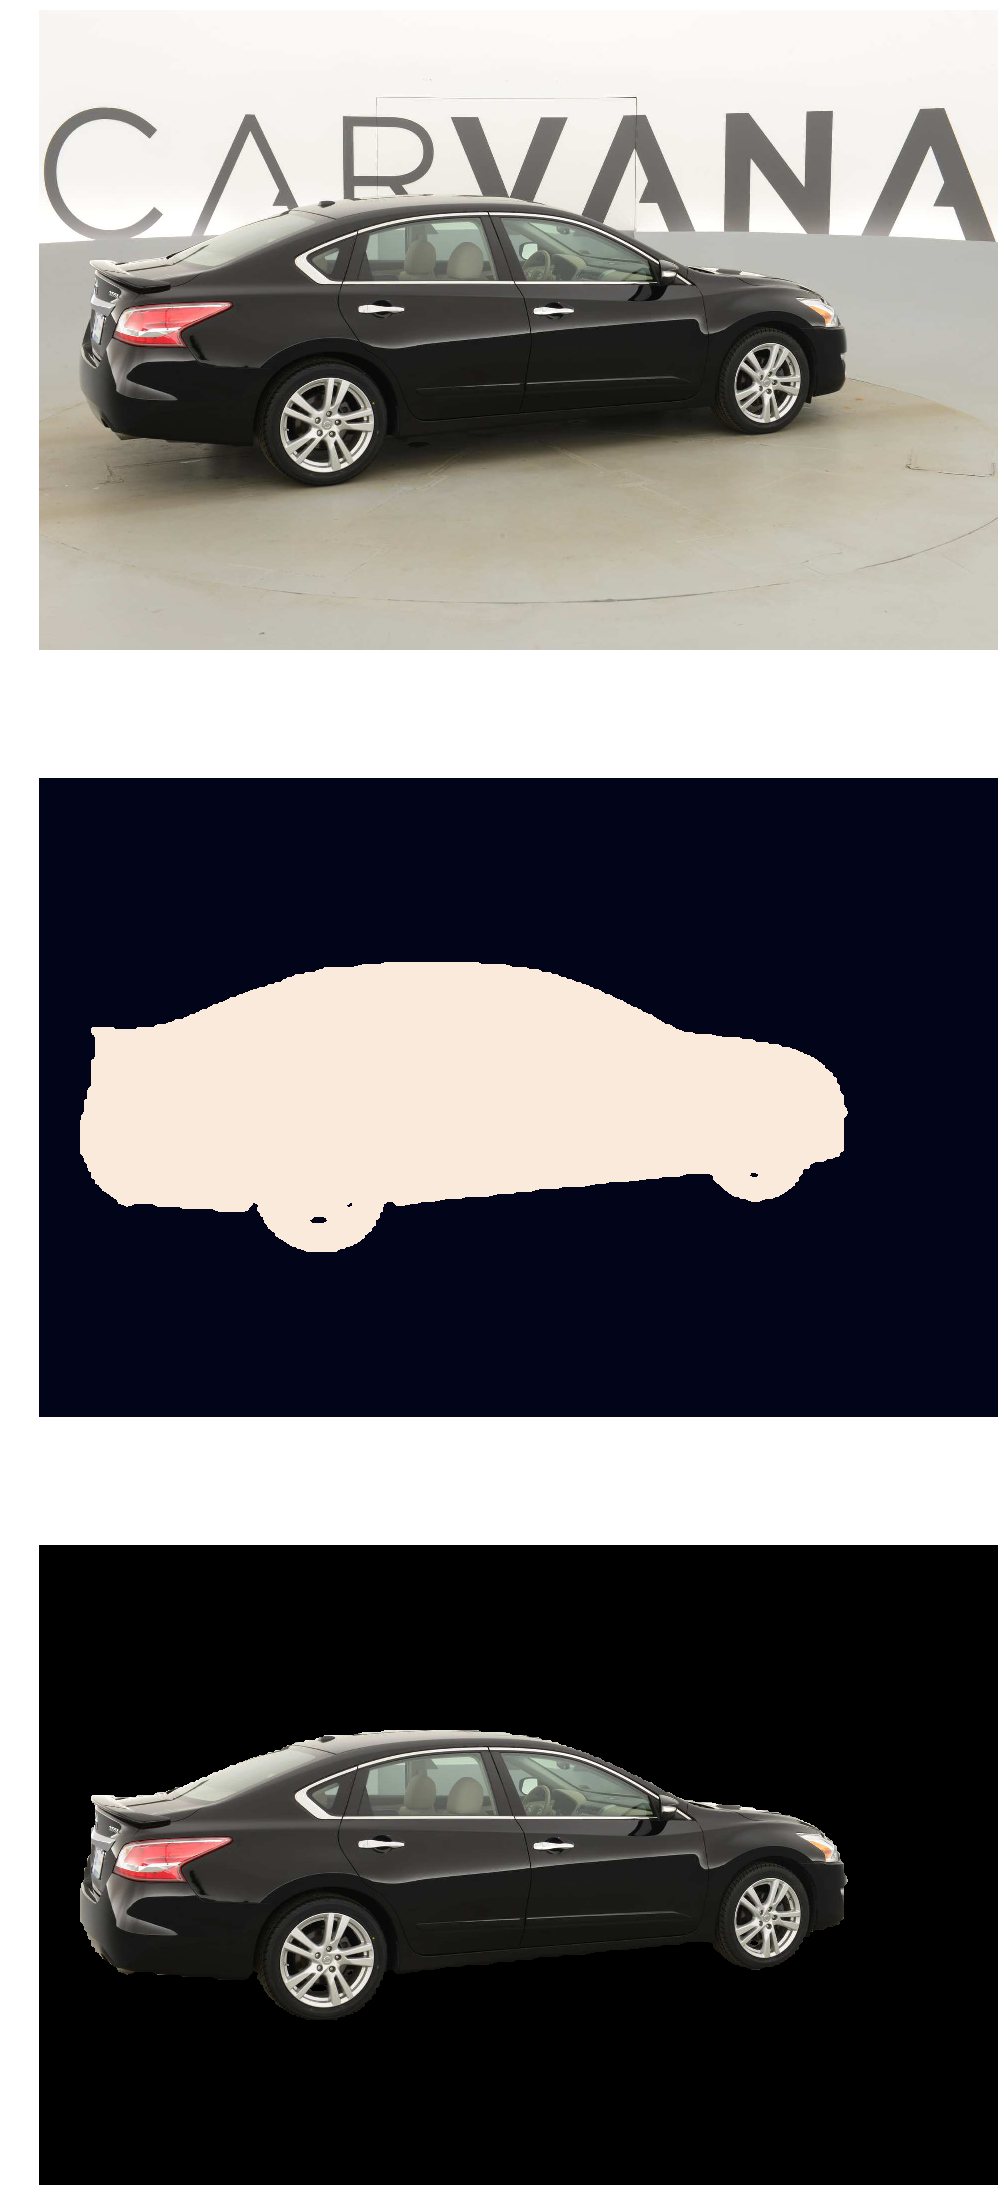

In [65]:
plt.figure(figsize=(40,40))
img = cv2.imread('test/{}'.format(submissions_csv['img'][100059]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle_decode(submissions_csv['rle_mask'][100059],(1280,1918,1))
masked_img = cv2.bitwise_and(img, img, mask=mask)

plt.figure(figsize=(40,40))
plt.subplot(3,1,1)
plt.axis('off')
plt.imshow(img)
plt.subplot(3,1,2)
plt.axis('off')
mask = mask.squeeze(axis = 2)
plt.imshow(mask)
plt.subplot(3,1,3)
plt.axis('off')
plt.imshow(masked_img)

#plt.tight_layout(w_pad=0.05)
plt.show()

As seen above, the model has done very well to get the finer details right on the mask such as the gaps we can see through the tyres. The coarse edges would be a result of lower resolution and small size images used for training and resizing them to get the output.

Let us see a few more examples output from the algorithm.

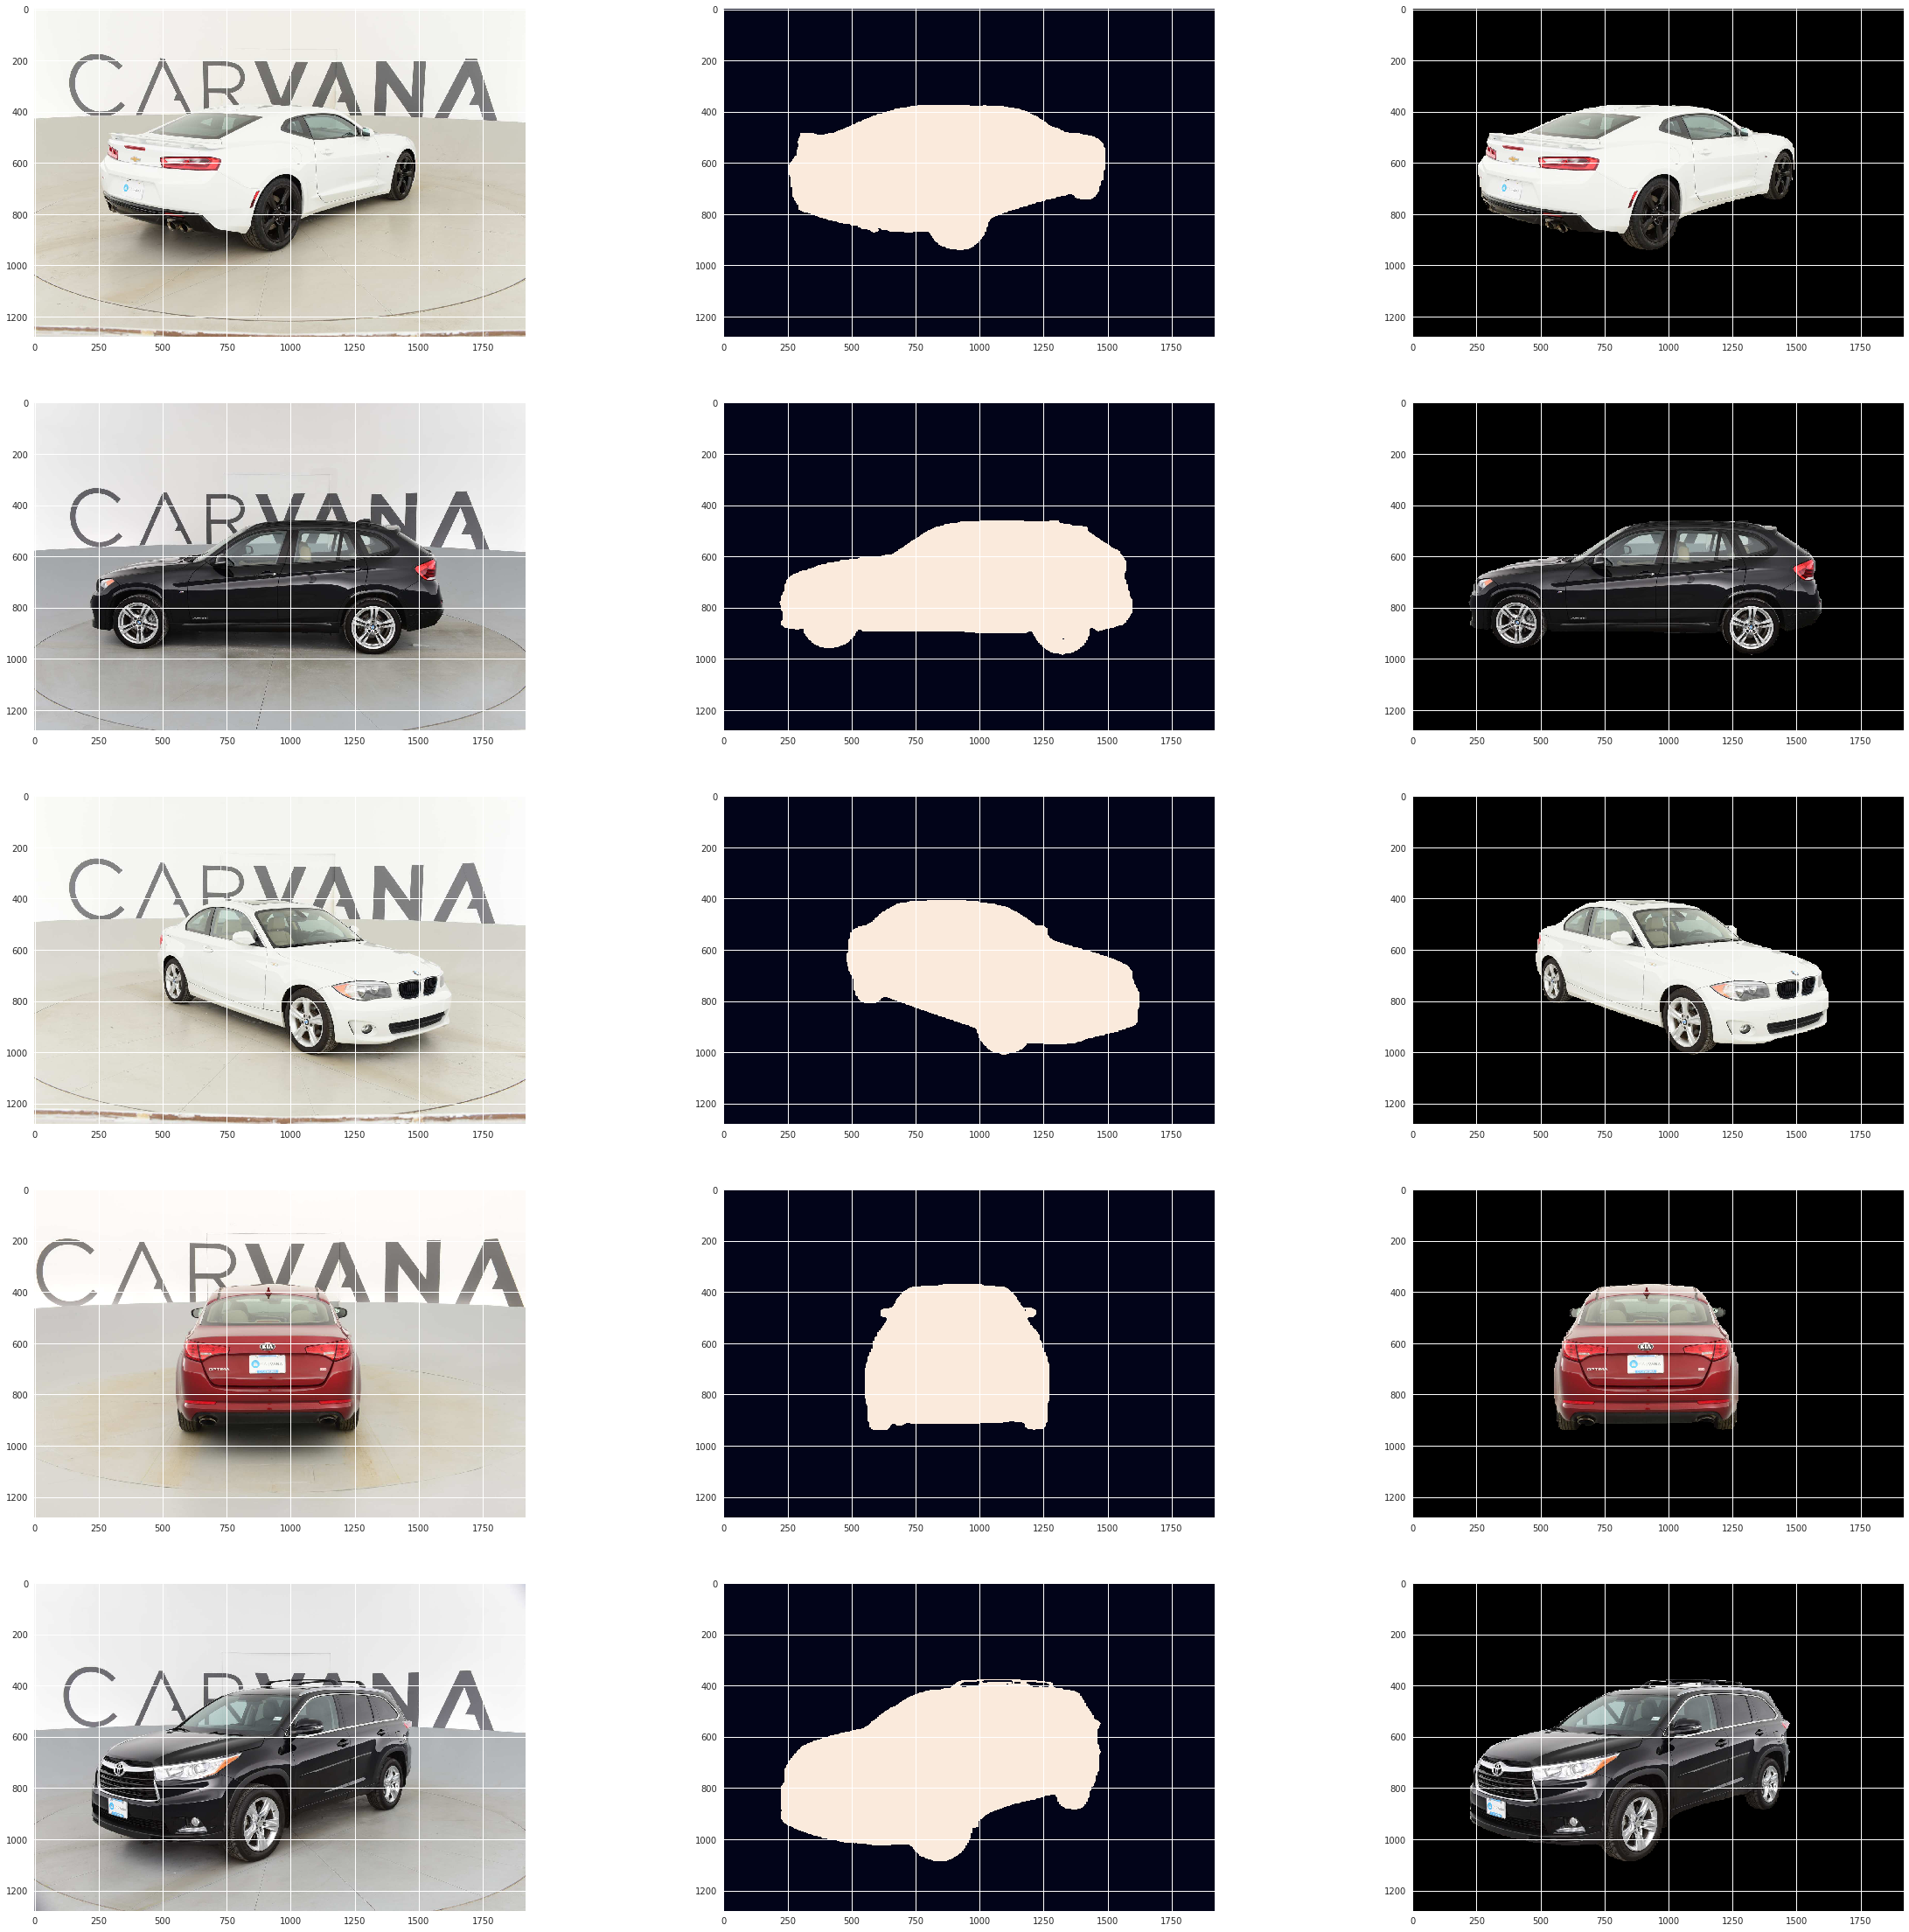

In [64]:
plt.figure(figsize=(40,40))
j = 0
for i in range(5):
    img = cv2.imread('test/{}'.format(submissions_csv['img'][42 + 42*i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle_decode(submissions_csv['rle_mask'][42 + 42*i],(1280,1918,1))
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    plt.subplot(5,3,j+1)
    plt.imshow(img)
    plt.subplot(5,3,j+2)
    mask = mask.squeeze(axis =2)
    plt.imshow(mask)
    plt.subplot(5,3,j+3)
    plt.imshow(masked_img)
    j +=3

plt.show()

- The model has correctly identified all the car edges and boundaries and even very fine details sucj as the gaps in the carrier grills and tyres. 
- As seen above, the mask output from our model is not very smooth for this size of the original size of the image.
- As we have predicted on just 256x256 images, we ended up with a very coarse output after resizing the image to its original pixels.
- To get an idea of how many pixels the model misclassified, we can use the dice score we received.
   - The car image is of size (1918, 1280) that is around 2.455M Pixels!
   - We got a score of 0.9944, that means we correctly segmented (0.9944 * 2.455M) i.e  2.441 M pixels!. 
   - Considering that we used just (256,256) sized images or ~65K pixels, its impressive, the model could correctly segment ~2.4M pixels. 
- The next obvious step to improve the results seems to be training with larger image sizes and on a powerful system that can handle these size of images with a good amount of images per batch. I will leave this to be explored in the future.